<a href="https://colab.research.google.com/github/ktrushina/dls_part_1/blob/main/20.%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%BE-%D1%81%D0%BE%D1%81%D1%82%D1%8F%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5%20%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8/seminar/%5Bseminar%5Dgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Семинар. Generative adversarial networks</b></h3>



В этом ноутбуке мы попробуем обучить GAN генерировать морды кошек из случайного шума. Датасет с кошками взят отсюда:
https://www.kaggle.com/spandan2/cats-faces-64x64-for-generative-models

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [ ]:
# !unzip archive.zip

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/MyDrive/cats/archive.zip -d DATA_SET

In [ ]:
from pathlib import Path
DATA_DIR = Path('DATA_SET') #DATA_DIR = './cats/'

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

Подготовим наши изображения к дальнейшему использованию

In [ ]:
train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size), #64 на 64
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

Посмотрим, как выглядит батч

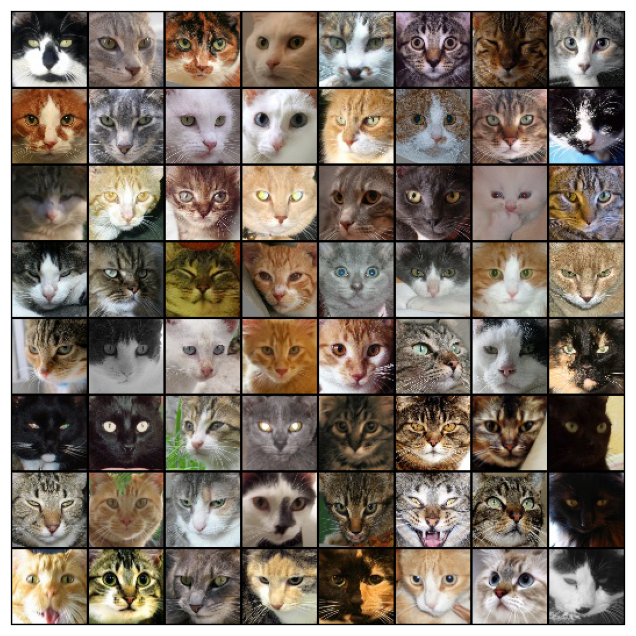

In [ ]:
show_batch(train_dl)

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

Давайте перейдем непосредственно к построению GANа. Напомним, что GAN состоит из двух сетей: *генератора*, задача которого – научиться генерировать изображения, похожие на обучающую выборку, из случайного шума, и *дискриминатора*, который учится распознавать, настоящее это изображение или сгенерированное генератором.

Построим генератор и дискриминатор на свертках:

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()) #чтобы получить вероятность принадлежности классу

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1 #вектор шума

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False), #обратные свертки
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh() # "Чтобы корректно выглядели цветные изображения" ?????????
    # out: 3 x 64 x 64
)

Посмотрим, как выглядит шум, из которого будут генерироваться изображения

torch.Size([128, 3, 64, 64])


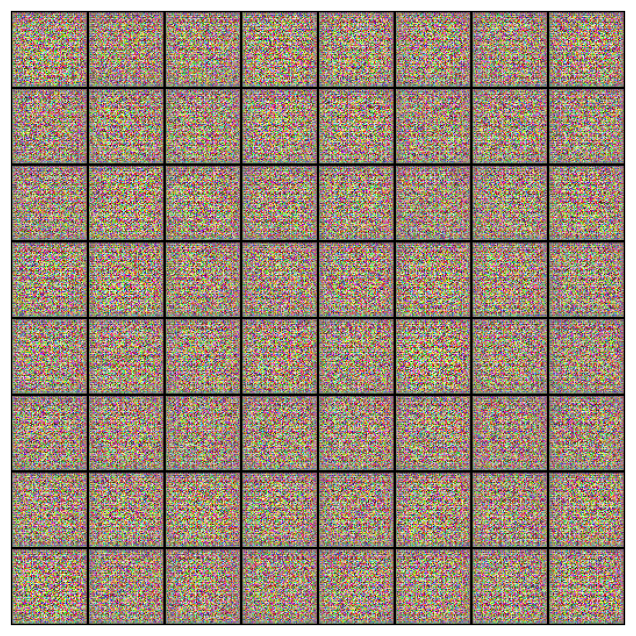

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(),
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }

    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device) #Присваиваем метку 1 для реальных изображений
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device) #берем латентные вектора и присваиваем метку 0
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)#присваиваем 1, чтобы обмануть дискриминатор
            loss_g = criterion["generator"](preds, targets)

            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs,
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))

        # Save generated images
        if epoch == epochs - 1:
          save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(), #бинарная кросс энтропия
    "generator": nn.BCELoss()
}
lr = 0.0002
epochs = 40

In [ ]:
history = fit(model, criterion, epochs, lr)


Epoch [1/40], loss_g: 7.7186, loss_d: 0.4274, real_score: 0.8579, fake_score: 0.1419



Epoch [2/40], loss_g: 4.1247, loss_d: 0.5732, real_score: 0.8024, fake_score: 0.1988



Epoch [3/40], loss_g: 3.6276, loss_d: 0.7646, real_score: 0.7442, fake_score: 0.2540



Epoch [4/40], loss_g: 4.4101, loss_d: 0.7000, real_score: 0.7680, fake_score: 0.2284



Epoch [5/40], loss_g: 4.8141, loss_d: 0.7038, real_score: 0.7747, fake_score: 0.2207



Epoch [6/40], loss_g: 4.7955, loss_d: 0.6645, real_score: 0.7890, fake_score: 0.2150



Epoch [7/40], loss_g: 5.0427, loss_d: 0.6965, real_score: 0.7895, fake_score: 0.2005



Epoch [8/40], loss_g: 4.5268, loss_d: 0.6425, real_score: 0.7956, fake_score: 0.2076



Epoch [9/40], loss_g: 4.6206, loss_d: 0.6608, real_score: 0.7861, fake_score: 0.2118



Epoch [10/40], loss_g: 4.4664, loss_d: 0.6637, real_score: 0.7948, fake_score: 0.2099



Epoch [11/40], loss_g: 4.4772, loss_d: 0.6583, real_score: 0.7940, fake_score: 0.2077



Epoch [12/40], loss_g: 4.4613, loss_d: 0.6603, real_score: 0.7905, fake_score: 0.2027



Epoch [13/40], loss_g: 4.5145, loss_d: 0.6606, real_score: 0.7902, fake_score: 0.2075



Epoch [14/40], loss_g: 4.5009, loss_d: 0.5707, real_score: 0.8104, fake_score: 0.1970



Epoch [15/40], loss_g: 4.5739, loss_d: 0.5914, real_score: 0.8066, fake_score: 0.1844



Epoch [16/40], loss_g: 4.5701, loss_d: 0.5889, real_score: 0.8182, fake_score: 0.1864



Epoch [17/40], loss_g: 4.3875, loss_d: 0.5618, real_score: 0.8161, fake_score: 0.1822



Epoch [18/40], loss_g: 4.3823, loss_d: 0.5074, real_score: 0.8276, fake_score: 0.1674



Epoch [19/40], loss_g: 4.8046, loss_d: 0.5331, real_score: 0.8270, fake_score: 0.1706



Epoch [20/40], loss_g: 4.6935, loss_d: 0.5671, real_score: 0.8330, fake_score: 0.1693



Epoch [21/40], loss_g: 4.4733, loss_d: 0.5367, real_score: 0.8277, fake_score: 0.1756



Epoch [22/40], loss_g: 5.0717, loss_d: 0.4435, real_score: 0.8562, fake_score: 0.1383



Epoch [23/40], loss_g: 4.8117, loss_d: 0.4228, real_score: 0.8639, fake_score: 0.1393



Epoch [24/40], loss_g: 5.2593, loss_d: 0.4317, real_score: 0.8666, fake_score: 0.1309



Epoch [25/40], loss_g: 5.2385, loss_d: 0.4182, real_score: 0.8700, fake_score: 0.1286



Epoch [26/40], loss_g: 5.3890, loss_d: 0.3510, real_score: 0.8873, fake_score: 0.1159



Epoch [27/40], loss_g: 5.3183, loss_d: 0.3749, real_score: 0.8815, fake_score: 0.1205



Epoch [28/40], loss_g: 5.6898, loss_d: 0.3895, real_score: 0.8818, fake_score: 0.1140



Epoch [29/40], loss_g: 5.2197, loss_d: 0.3295, real_score: 0.8952, fake_score: 0.1067



Epoch [30/40], loss_g: 5.3538, loss_d: 0.2841, real_score: 0.9058, fake_score: 0.0933



Epoch [31/40], loss_g: 5.7928, loss_d: 0.3408, real_score: 0.9000, fake_score: 0.0953



Epoch [32/40], loss_g: 5.6338, loss_d: 0.3392, real_score: 0.8935, fake_score: 0.1070



Epoch [33/40], loss_g: 6.5600, loss_d: 0.2432, real_score: 0.9391, fake_score: 0.0674



Epoch [34/40], loss_g: 6.0082, loss_d: 0.4359, real_score: 0.8780, fake_score: 0.1215



Epoch [35/40], loss_g: 5.4537, loss_d: 0.2725, real_score: 0.9056, fake_score: 0.0911



Epoch [36/40], loss_g: 6.4370, loss_d: 0.2910, real_score: 0.9131, fake_score: 0.0867



Epoch [37/40], loss_g: 5.5319, loss_d: 0.2486, real_score: 0.9140, fake_score: 0.0878



Epoch [38/40], loss_g: 5.9590, loss_d: 0.2846, real_score: 0.9076, fake_score: 0.0879



Epoch [39/40], loss_g: 5.6119, loss_d: 0.2916, real_score: 0.9097, fake_score: 0.0954



Epoch [40/40], loss_g: 5.9771, loss_d: 0.1904, real_score: 0.9296, fake_score: 0.0693
Saving generated-images-0040.png


Посмотрим на результаты обучения. Вот так выглядят котики, сгенерированные на последней эпохе обучения:

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
generated_img = cv2.imread(f'./generated/generated-images-00{epochs}.png')
generated_img = generated_img[:, :, [2, 1, 0]]

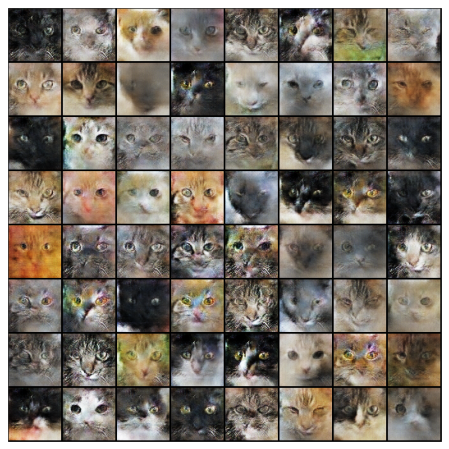

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

Как мы видим, изображение в целом получается похожим, однако есть много артефактов

Посмотрим на графики loss генератора и дискриминатора и score дискриминатора

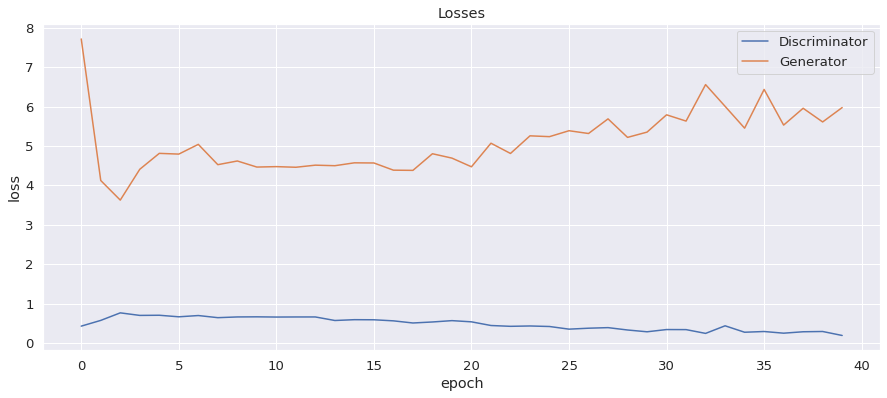

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

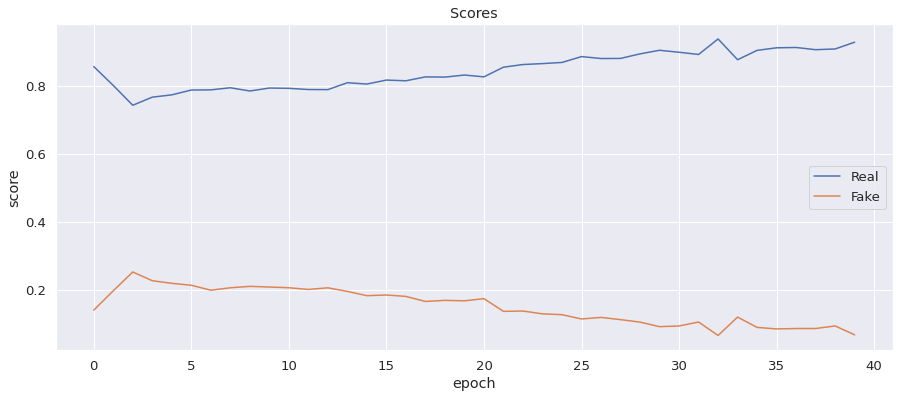

In [ ]:
#Для реальных изображений получаем что-то близкое к 1, а для фейковых получили что-то близкое к 0

plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

Поведение графиков примерно такое же, как было показано на лекции